In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from time import time
import lightgbm as lgb

In [2]:
store=pd.read_csv(r'data\store.csv')
train=pd.read_csv(r'data\train.csv',dtype={'StateHoliday':pd.np.string_})
test=pd.read_csv(r'data\test.csv',dtype={'StateHoliday':pd.np.string_})

In [3]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [4]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [5]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [6]:
train[train['Store']==622]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
621,622,5,2015-07-31,6306,540,1,1,0,1
1736,622,4,2015-07-30,5412,406,1,1,0,1
2851,622,3,2015-07-29,5326,468,1,1,0,1
3966,622,2,2015-07-28,4966,417,1,1,0,1
5081,622,1,2015-07-27,5413,517,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1012256,622,6,2013-01-05,2350,258,1,0,0,0
1013371,622,5,2013-01-04,3675,399,1,0,0,1
1014486,622,4,2013-01-03,4085,419,1,0,0,1
1015601,622,3,2013-01-02,4080,451,1,0,0,1


In [7]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
test.fillna(1,inplace=True)

In [9]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [10]:
a1='CompetitionDistance'
a2='CompetitionOpenSinceMonth'
a3='CompetitionOpenSinceYear'
a4='Promo2SinceWeek'
a5='Promo2SinceYear'
a6='PromoInterval'

In [11]:
store[(store[a2].isnull())&(store[a3].isnull())].shape

(354, 10)

In [12]:
store[(store[a4].isnull())&(store[a5].isnull())&(store[a6].isnull())].shape

(544, 10)

In [13]:
store.fillna(0,inplace=True)

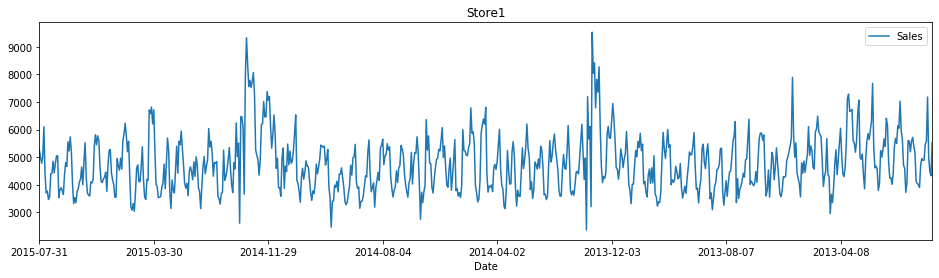

In [14]:
strain=train[train['Sales']>0]
strain.loc[strain['Store']==1,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

In [15]:
#我们只需要销售额大于0的数据
train=train[train['Sales']>0]
#把store基本信息合并到训练和测试数据集上
train=pd.merge(train,store,on='Store',how='left')
test=pd.merge(test,store,on='Store',how='left')

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 18 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null object
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
Promo2SinceYear              844338 non-null float64
PromoInt

In [16]:
for data in [train,test]:
	#将时间特征进行拆分和转化
    data['year']=data['Date'].apply(lambda x:x.split('-')[0])
    data['year']=data['year'].astype(int)
    data['month']=data['Date'].apply(lambda x:x.split('-')[1])
    data['month']=data['month'].astype(int)
    data['day']=data['Date'].apply(lambda x:x.split('-')[2])
    data['day']=data['day'].astype(int)
	#将'PromoInterval'特征转化为'IsPromoMonth'特征，表示某天某店铺是否处于促销月，1表示是，0表示否
	#提示下：这里尽量不要用循环，用这种广播的形式，会快很多。循环可能会让你等的想哭
    month2str={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    data['monthstr']=data['month'].map(month2str)
    data['IsPromoMonth']=data.apply(lambda x:0 if x['PromoInterval']==0 else 1 if x['monthstr'] in x['PromoInterval'] else 0,axis=1)
	#将存在其它字符表示分类的特征转化为数字

    mappings = {'0':0,'a':1,'b':2,'c':3,'d':4}

    data['StoreType'].replace(mappings,inplace=True)
    data['Assortment'].replace(mappings,inplace=True)
    data['StateHoliday'].replace(mappings,inplace=True)

In [17]:
df_train=train.drop(['Date','Customers','Open','PromoInterval','monthstr'],axis=1)
df_test=test.drop(['Id','Date','Open','PromoInterval','monthstr'],axis=1)
#如上所述，保留训练集中最近六周的数据用于后续模型的测试
Xtrain=df_train[6*7*1115:]
Xtest=df_train[:6*7*1115]

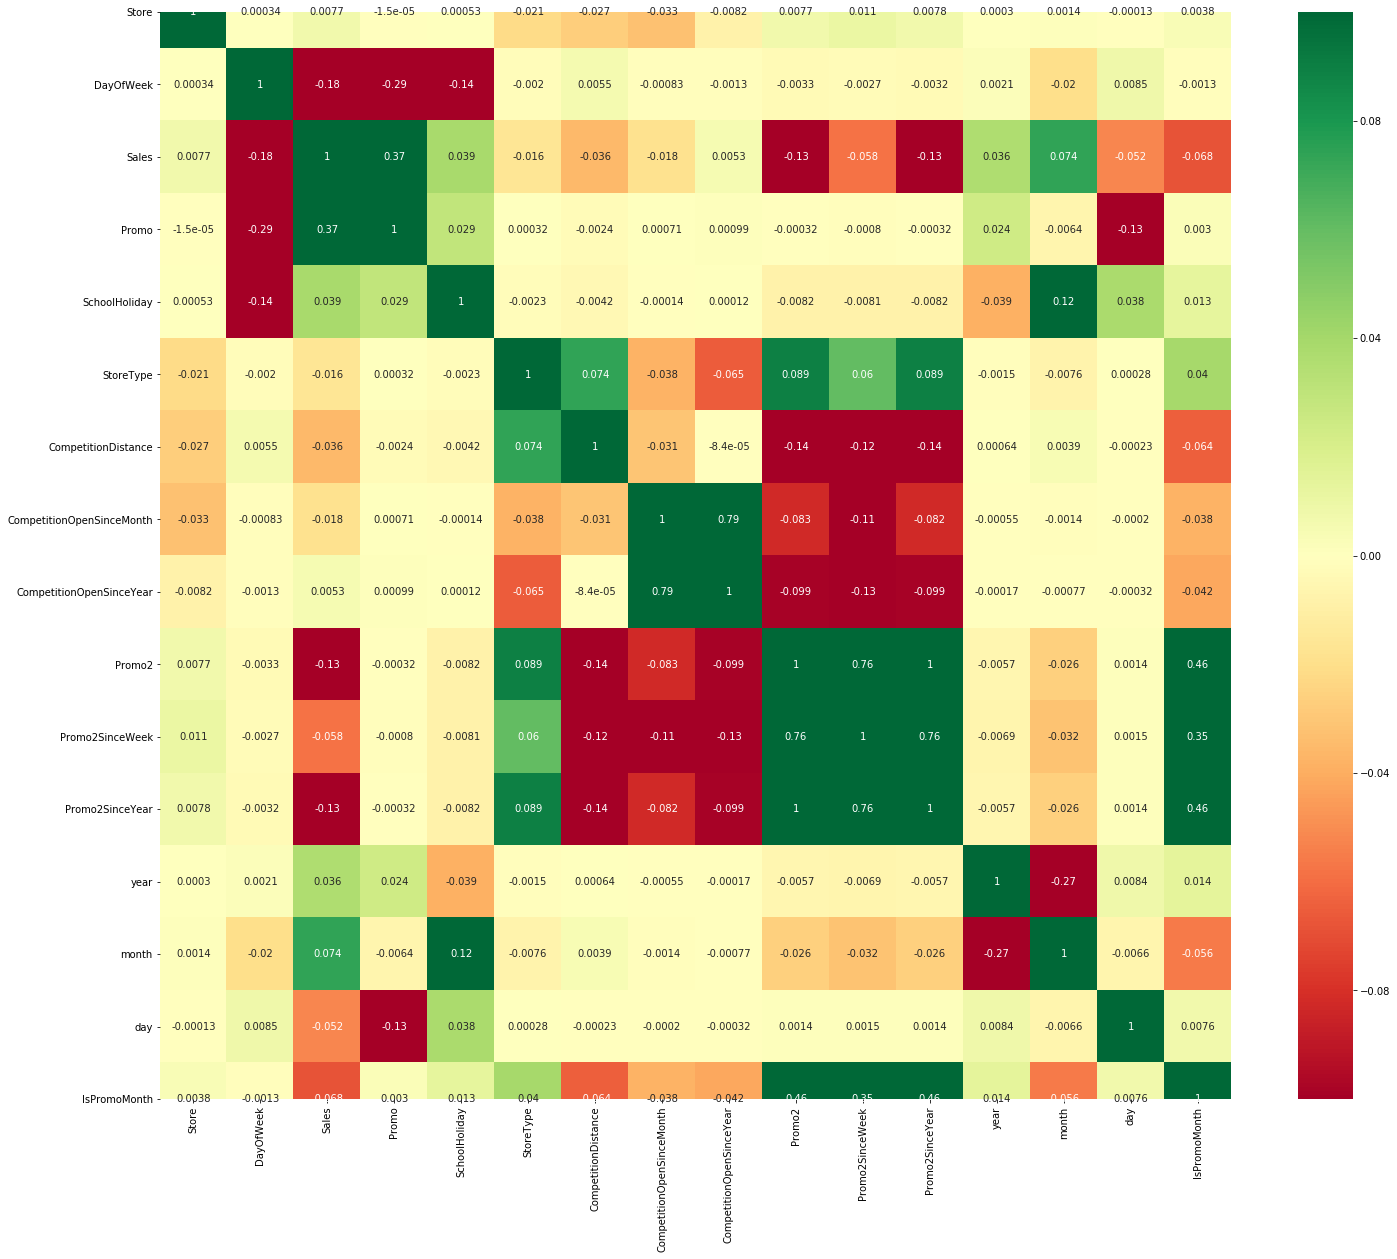

In [18]:
plt.subplots(figsize=(24,20))
sns.heatmap(df_train.corr(),cmap='RdYlGn',annot=True,vmin=-0.1,vmax=0.1,center=0)

In [19]:
ytrain=np.log1p(Xtrain['Sales'])
ytest=np.log1p(Xtest['Sales'])

Xtrain=Xtrain.drop(['Sales'],axis=1)
Xtest=Xtest.drop(['Sales'],axis=1)

In [20]:
#定义评价函数，可以传入后面模型中替代模型本身的损失函数
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))

def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

In [21]:
#初始模型构建
#参数设定
params={'objective':'reg:linear',
       'booster':'gbtree',
       'eta':0.03,
       'max_depth':10,
       'subsample':0.9,
       'colsample_bytree':0.7,
       'silent':1,
       'seed':10}
num_boost_round=6000

In [24]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
Xtrain['StateHoliday'] = lbl.fit_transform(Xtrain['StateHoliday'].astype(str))#将提示的包含错误数据类型这一列进行转换
Xtest['StateHoliday'] = lbl.fit_transform(Xtest['StateHoliday'].astype(str))
Xtrain['Assortment'] = lbl.fit_transform(Xtrain['Assortment'].astype(str))
Xtest['Assortment'] = lbl.fit_transform(Xtest['Assortment'].astype(str))

In [25]:
dtrain=xgb.DMatrix(Xtrain,ytrain)
dvalid=xgb.DMatrix(Xtest,ytest)

d:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [34]:
train_data = lgb.Dataset(Xtrain,ytrain)
param = {
    'num_leaves':150, 
    'objective':'binary',
    'max_depth':7,
    'learning_rate':.05,
    'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

In [26]:
Xtrain

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,year,month,day,IsPromoMonth
46830,948,6,0,0,0,2,1,1430.0,0.0,0.0,0,0.0,0.0,2015,6,13,0
46831,949,6,0,0,0,1,0,870.0,3.0,2006.0,0,0.0,0.0,2015,6,13,0
46832,950,6,0,0,0,1,0,8460.0,11.0,1994.0,0,0.0,0.0,2015,6,13,0
46833,951,6,0,0,0,4,2,710.0,0.0,0.0,1,40.0,2011.0,2015,6,13,0
46834,952,6,0,0,0,4,2,6300.0,10.0,2013.0,0,0.0,0.0,2015,6,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,2,0,1,1,2,0,150.0,9.0,2006.0,0,0.0,0.0,2013,1,1,0
844334,733,2,0,1,1,2,1,860.0,10.0,1999.0,0,0.0,0.0,2013,1,1,0
844335,769,2,0,1,1,2,1,840.0,0.0,0.0,1,48.0,2012.0,2013,1,1,1
844336,948,2,0,1,1,2,1,1430.0,0.0,0.0,0,0.0,0.0,2013,1,1,0


In [27]:
df_train.head()

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,year,month,day,IsPromoMonth
0,1,5,5263,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,31,0
1,2,5,6064,1,0,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,2015,7,31,1
2,3,5,8314,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,2015,7,31,1
3,4,5,13995,1,0,1,3,3,620.0,9.0,2009.0,0,0.0,0.0,2015,7,31,0
4,5,5,4822,1,0,1,1,1,29910.0,4.0,2015.0,0,0.0,0.0,2015,7,31,0


In [29]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797508 entries, 46830 to 844337
Data columns (total 17 columns):
Store                        797508 non-null int64
DayOfWeek                    797508 non-null int64
Promo                        797508 non-null int64
StateHoliday                 797508 non-null int32
SchoolHoliday                797508 non-null int64
StoreType                    797508 non-null int64
Assortment                   797508 non-null int32
CompetitionDistance          797508 non-null float64
CompetitionOpenSinceMonth    797508 non-null float64
CompetitionOpenSinceYear     797508 non-null float64
Promo2                       797508 non-null int64
Promo2SinceWeek              797508 non-null float64
Promo2SinceYear              797508 non-null float64
year                         797508 non-null int32
month                        797508 non-null int32
day                          797508 non-null int32
IsPromoMonth                 797508 non-null int64
dtypes: 

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null int64
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
year                         41088 non-null int32
month                        41088 non-null int32
day                          41088 non-null int32
IsPromoMonth                 41088 non-null int64
dtypes: float64(5), int32(3),

In [39]:
watchlist=[(dtrain,'train'),(dvalid,'eval')]

#模型训练
print('Train a XGBoost model')
start=time()
gbm=xgb.train(params,dtrain,num_boost_round,evals=watchlist,
             early_stopping_rounds=100,feval=rmspe_xg,verbose_eval=True)
end=time()
print('Train time is {:.2f} s.'.format(end-start))

n-rmspe:0.095775	eval-rmspe:0.128651
[2336]	train-rmse:0.07745	eval-rmse:0.119228	train-rmspe:0.095765	eval-rmspe:0.128647
[2337]	train-rmse:0.077436	eval-rmse:0.119221	train-rmspe:0.095681	eval-rmspe:0.128639
[2338]	train-rmse:0.077427	eval-rmse:0.119222	train-rmspe:0.095674	eval-rmspe:0.128642
[2339]	train-rmse:0.07742	eval-rmse:0.119225	train-rmspe:0.095668	eval-rmspe:0.128644
[2340]	train-rmse:0.077412	eval-rmse:0.119225	train-rmspe:0.095663	eval-rmspe:0.128646
[2341]	train-rmse:0.077403	eval-rmse:0.119238	train-rmspe:0.095627	eval-rmspe:0.128667
[2342]	train-rmse:0.077393	eval-rmse:0.119239	train-rmspe:0.095615	eval-rmspe:0.128669
[2343]	train-rmse:0.077384	eval-rmse:0.119242	train-rmspe:0.095606	eval-rmspe:0.12867
[2344]	train-rmse:0.077381	eval-rmse:0.119241	train-rmspe:0.095602	eval-rmspe:0.12867
[2345]	train-rmse:0.077378	eval-rmse:0.119236	train-rmspe:0.095599	eval-rmspe:0.128664
[2346]	train-rmse:0.077369	eval-rmse:0.119242	train-rmspe:0.095587	eval-rmspe:0.12867
[2347]	trai

In [41]:
dtrain.info()

AttributeError: 'DMatrix' object has no attribute 'info'

In [43]:
df_test['StateHoliday'] = lbl.fit_transform(df_test['StateHoliday'].astype(str))
df_test['Assortment'] = lbl.fit_transform(df_test['Assortment'].astype(str))

In [45]:
dtest = xgb.DMatrix(df_test)

In [47]:
pred = gbm.predict(dtest)

In [88]:
result = pd.DataFrame({'Id':test["Id"].values, 'Sales':pred.astype(np.float64)})
result.head()

,Id,Sales
0,1,8.323410
1,2,8.932504
2,3,9.070481
3,4,8.910243
4,5,8.931108


In [91]:
result.to_csv("xgb_pred_Rossmann_Store.csv", index=False)

In [100]:
ytrain.head().values

array([8.76545853, 8.01895468, 8.35420356, 8.95776801, 8.69282576])

In [93]:
xpred = gbm.predict(xgb.DMatrix(Xtrain.head()))

In [101]:
xpred

array([8.720669 , 8.030263 , 8.317345 , 8.9363785, 8.77961  ],
      dtype=float32)

In [102]:
xpred-ytrain.head().values

array([-0.04478974,  0.01130826, -0.0368589 , -0.02138953,  0.08678392])